In [55]:
from decouple import config
import os
import pandas as pd
from nilearn import datasets, plotting, image
from sklearn import linear_model
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from fNeuro.utils.pickling import load_pickle 
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import re
import numpy as np

In [8]:
resting_path = config('resting')
autistic_traits = pd.read_csv(os.path.join(resting_path, 'autistic_traits_neuroimaging.csv'))
autistic_traits['B_Number'] = autistic_traits['B_Number'].str.rstrip()
autistic_traits = autistic_traits.drop(autistic_traits[autistic_traits['B_Number'].str.contains('B2010')].index).reset_index(drop=True)
autistic_traits['B_Number'].loc[autistic_traits[autistic_traits['B_Number'] == 'B2024b'].index[0]] = 'B2024'
connectome = load_pickle(os.path.join(resting_path, 'measures', 'connectome'))
participant_order = load_pickle(os.path.join(resting_path, 'measures', 'connectome_participant_order'))
order = [re.findall('B\d\d\d\d', participant)[0] for participant in participant_order]
connectome_dict = dict(zip(order, connectome))
msdl = datasets.fetch_atlas_msdl()
msdl_overview_df = pd.DataFrame({'labels': msdl['labels'],
                                  'networks': msdl['networks'],
                                  'region_coords': msdl['region_coords']
                                  })


/tmp/ipykernel_258837/2042850535.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  autistic_traits['B_Number'].loc[autistic_traits[autistic_traits['B_Number'] == 'B2024b'].index[0]] = 'B2024'


TODO

Improve accuracy

In [46]:
aq_df = autistic_traits[['B_Number', 'aq10']].dropna().reset_index(drop=True)
y_aq = aq_df['aq10'].values
x_aq = np.array([connectome_dict.get(key) for key in aq_df['B_Number'].values])

<Axes: ylabel='Count'>

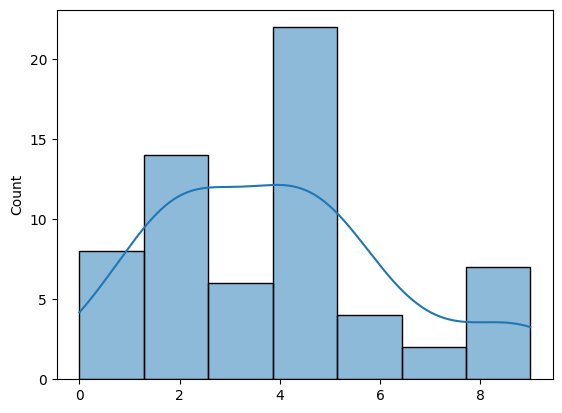

In [67]:
sns.histplot(data=y_aq, kde=True)

In [47]:
def estimate_regression_model(model, X, y):
    cv = StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.2, train_size=0.8)
    return {
        'r2': cross_val_score(model, X, y, cv=cv, scoring='r2', n_jobs=2),
        'MAE': cross_val_score(model, X, y, cv=cv, scoring='neg_mean_absolute_error', n_jobs=2),
        'MSE': cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=2),
    }

In [53]:
lasso = linear_model.LassoCV()
scores_lasso = estimate_regression_model(lasso, x_aq, y_aq)
print(scores_lasso['r2'].mean())
print(scores_lasso['MAE'].mean())
print(scores_lasso['MSE'].mean())

-0.04109893014229602
-2.106476217021792
-6.622354366252997


In [48]:
bayes_ridge = linear_model.BayesianRidge()
scores_bayesian = estimate_regression_model(bayes_ridge, x_aq, y_aq)
print(scores_bayesian['r2'].mean())
print(scores_bayesian['MAE'].mean())
print(scores_bayesian['MSE'].mean())

-0.14860701557066974
-2.2532884001792945
-7.28652038212343


In [49]:
from sklearn import svm
svc_parameters = {'C': [1e0, 1e1, 1e2]}
svm_regression = GridSearchCV(svm.SVR(kernel="linear", gamma="auto"), svc_parameters)
scores_svm = estimate_regression_model(svm_regression, x_aq, y_aq)
print(scores_svm['r2'].mean())
print(scores_svm['MAE'].mean())
print(scores_svm['MSE'].mean())

-0.13598602379792069
-2.2388638709125024
-7.2054762212838765


In [50]:
from sklearn.linear_model import LinearRegression
rob = LinearRegression()
score_rob = estimate_regression_model(rob, x_aq, y_aq)
print(score_rob['r2'].mean())
print(score_rob['MAE'].mean())
print(score_rob['MSE'].mean())

-0.1488849861120561
-2.253319004483862
-7.288357413989028


In [83]:
from sklearn.ensemble import RandomForestRegressor
tree_parm = {'max_depth':[5, 7]}
ran_forest = GridSearchCV(RandomForestRegressor(random_state=0), tree_parm)
score_ran = estimate_regression_model(ran_forest, x_aq, y_aq)
print(score_ran['r2'].mean())
print(score_ran['MAE'].mean())
print(score_ran['MSE'].mean())

0.043762332332428655
-2.055992733441772
-6.0804249625405635


In [82]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
ttr = TransformedTargetRegressor(regressor=RandomForestRegressor(), transformer=QuantileTransformer(output_distribution='uniform'))
scores_ttr = estimate_regression_model(ttr, x_aq, y_aq)
print(scores_ttr['r2'].mean())
print(scores_ttr['MAE'].mean())
print(scores_ttr['MSE'].mean())

/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (50). n_quantiles is set to n_samples.
  warnings.warn(
/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (50). n_quantiles is set to n_samples.
  warnings.warn(
/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (50). n_quantiles is set to n_samples.
  warnings.warn(
/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (50). n_quantiles is set to n_samples.
  warnings.warn(
/home/k1812017/.conda/envs/neuroimaging/lib/pyth

-0.04464910197392091
-2.0589999999999997
-6.599668653846156


In [38]:
from sklearn.linear_model import ElasticNet

elast_net_parameters = {'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
regr = GridSearchCV(ElasticNet(random_state=0), elast_net_parameters)
score_elast = estimate_regression_model(regr, x_aq, y_aq)
print(score_elast['r2'].mean())

/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.151e-02, tolerance: 1.990e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.555e-02, tolerance: 1.875e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted u

-0.4587993087438315


/home/k1812017/.conda/envs/neuroimaging/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.983e-02, tolerance: 2.305e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
